### Loading Libraries

In [1]:
import os
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
import numpy as np
import zipfile
import anndata
import joblib
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2022-06-28 21:28:14.534323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/uqomulay/.conda/envs/gmlp_stimage/lib/python3.8/site-packages/cv2/../../lib64:/opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2022-06-28 21:28:14.534387: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### ResNet50 and Logistic Regression

In [2]:
#Computing ResNet50 features
def ResNet50_features(unzipped_file, pre_model):
    files = pd.DataFrame(unzipped_file.namelist()).iloc[1:,:][0]
    x_scratch_train = []
    for imagePath in files:
        image = plt.imread(unzipped_file.open(imagePath)).astype('float32')
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        x_scratch_train.append(image)
    x_train = np.vstack(x_scratch_train)
    resnet_features = pd.DataFrame(pre_model.predict(x_train, batch_size=1))
    resnet_features["tile_tissue_mask_path"] = files.str.split('/', expand=True)[1].str[:-5].to_list()
    return resnet_features


#Training Pre-Processing
def LR_model(Path, gene_list, train_data_library_id, resnet_features):
    h5ad = anndata.obs #h5ad = pd.read_csv(Path+"h5ad_obs.csv", index_col=0) #
    gene_exp = anndata.to_df()[gene_list] #gene_exp = pd.read_csv(Path+"gene_expression_visium.csv", index_col=0) 

    resnet_features_h5ad = pd.DataFrame(index=h5ad.index)
    resnet_features_h5ad.index.name = "anndata_index"
    resnet_features_h5ad['tile_tissue_mask_path'] = h5ad['tile_tissue_mask_path'].str.split('/', expand=True)[3].str[:-5]
    resnet_features_h5ad = resnet_features_h5ad.reset_index()    
    resnet_features = resnet_features.merge(resnet_features_h5ad, on='tile_tissue_mask_path')
    resnet_features.drop(columns=["tile_tissue_mask_path"],inplace=True)
    resnet_features = resnet_features.set_index("anndata_index")
    resnet_features = resnet_features.reindex(h5ad.index)

    resnet_features['dataset'] = h5ad['library_id']
    resnet_features.to_csv(Path+"resnet50_features.csv")
    gene_exp['dataset'] = h5ad['library_id']
    

    #Training Data Split, Binarization and #Prediction
    gene_exp_zscore = gene_exp.groupby('dataset')[gene_list].apply(lambda x: (x-x.mean())/(x.std()))
    gene_exp_binary = gene_exp_zscore.apply(lambda x: [0 if y <= 0 else 1 for y in x])
    gene_exp_binary['dataset'] = gene_exp['dataset']
    gene_exp_binary.to_csv(Path+"transformed_gene_expression.csv")

    model_c = LogisticRegression(max_iter=10000,penalty='elasticnet',C=0.1,solver='saga',l1_ratio=0.5)
    clf_resnet = MultiOutputClassifier(model_c).fit(resnet_features.loc[(resnet_features['dataset'].isin(train_data_library_id))].iloc[:,:-1], gene_exp_binary.loc[(gene_exp_binary['dataset'].isin(train_data_library_id))].iloc[:,:-1])
    joblib.dump(clf_resnet, Path+'pickle/LRmodel.pkl')
    clf_resnet = joblib.load(Path+'pickle/LRmodel.pkl')
    pred_gexp = pd.DataFrame(clf_resnet.predict(resnet_features.loc[~(resnet_features['dataset'].isin(train_data_library_id))].iloc[:,:-1]),columns=gene_exp_binary.iloc[:,:-1].columns,index=resnet_features.loc[~(resnet_features['dataset'].isin(train_data_library_id))].index)
    pred_gexp['dataset'] = resnet_features.loc[~(resnet_features['dataset'].isin(train_data_library_id))]['dataset']

    performance_metrics_all_predictions = [x for _, x in pred_gexp.groupby('dataset')]
    gene_exp_binary_all_true = [x for _, x in gene_exp_binary.loc[~(gene_exp_binary['dataset'].isin(train_data_library_id))].groupby('dataset')]
    return gene_exp_binary, pred_gexp, performance_metrics_all_predictions, gene_exp_binary_all_true

### Performance Evaluation with exceptional handling

In [3]:
#Boxplot of Performance Metrics
def performance_metrics_exceptional(Path, gene_exp_binary_all_true, performance_metrics_all_predictions, gene_list):
    AUROC_genes = []; F1_genes = []; Precision_genes = []; Recall_genes = []
    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  roc_auc_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                AUROC_genes.append(score)
            except:
                AUROC_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  f1_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                F1_genes.append(score)
            except:
                F1_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  precision_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                Precision_genes.append(score)
            except:
                Precision_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  recall_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                Recall_genes.append(score)
            except:
                Recall_genes.append(score)

    AUROC_genes = pd.DataFrame(AUROC_genes); F1_genes = pd.DataFrame(F1_genes); Precision_genes = pd.DataFrame(Precision_genes); Recall_genes = pd.DataFrame(Recall_genes)
    Performance_metrics = pd.concat([AUROC_genes,F1_genes,Precision_genes,Recall_genes])
    Performance_metrics['patient'] = list(np.repeat(pd.concat(gene_exp_binary_all_true).loc[~(pd.concat(gene_exp_binary_all_true)['dataset'].isin(train_data_library_id))].drop_duplicates('dataset', keep='first')['dataset'].to_list(),len(gene_list)))*4
    Performance_metrics['genes'] = gene_list*len(set(Performance_metrics['patient']))*4
    Performance_metrics['measure'] = ['AUROC']*len(AUROC_genes)+['F1']*len(F1_genes)+['Precision']*len(Precision_genes)+['Recall']*len(Recall_genes)

    plt.figure(figsize=(19.20,10.80))
    im = sns.boxplot(x="patient", y=0, hue="measure", data=Performance_metrics,linewidth=4)
    im.axhline(0.5, linewidth=2, color='r')
    return im.figure.savefig(Path+'Classification_boxplot.png')

### Performance Evaluation

In [53]:
def performance_metrics(Path, gene_exp_binary_all_true, performance_metrics_all_predictions, gene_list):
    gene_exp_binary_all_true = [df for df in gene_exp_binary_all_true if not df.empty]
    performance_metrics_all_predictions = [df for df in performance_metrics_all_predictions if not df.empty]
    AUROC_genes = []; F1_genes = []; Precision_genes = []; Recall_genes = []
    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            score =  roc_auc_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                                   gene_exp_binary_all_true[dataset].iloc[:,gene])
            AUROC_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            score =  f1_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                                   gene_exp_binary_all_true[dataset].iloc[:,gene])
            F1_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            score =  precision_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                                   gene_exp_binary_all_true[dataset].iloc[:,gene])
            Precision_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            score =  recall_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                                   gene_exp_binary_all_true[dataset].iloc[:,gene])
            Recall_genes.append(score)

    AUROC_genes = pd.DataFrame(AUROC_genes); F1_genes = pd.DataFrame(F1_genes); Precision_genes = pd.DataFrame(Precision_genes); Recall_genes = pd.DataFrame(Recall_genes)
    Performance_metrics = pd.concat([AUROC_genes,F1_genes,Precision_genes,Recall_genes])
    Performance_metrics['patient'] = list(np.repeat(pd.concat(gene_exp_binary_all_true).loc[~(pd.concat(gene_exp_binary_all_true)['dataset'].isin(train_data_library_id))].drop_duplicates('dataset', keep='first')['dataset'].to_list(),len(gene_list)))*4
    Performance_metrics['genes'] = gene_list*len(set(Performance_metrics['patient']))*4
    Performance_metrics['measure'] = ['AUROC']*len(AUROC_genes)+['F1']*len(F1_genes)+['Precision']*len(Precision_genes)+['Recall']*len(Recall_genes)

    sns.set(font_scale = 2, style="whitegrid",)
    plt.figure(figsize=(22.50,12.50))
    plt.ylim(-0.1, 1.10)
    im = sns.boxplot(x="patient", y=0, hue="measure", data=Performance_metrics,linewidth=3.5,width=0.6)
    im.set_xticklabels(im.get_xticklabels(),rotation = 30)
    plt.legend(loc="lower right", frameon=True, fontsize=20)
    im.axhline(0.5, linewidth=2, color='r')
    
    sns.set(font_scale = 2, style="whitegrid",)
    plt.figure(figsize=(22.50,12.50))
    plt.ylim(-0.1, 1.10)
    im2 = sns.boxplot(x="genes", y=0, hue="measure", data=Performance_metrics,linewidth=3.5,width=0.6)
    im2.set_xticklabels(im2.get_xticklabels(),rotation = 30)
    plt.legend(loc="lower right", frameon=True, fontsize=20)
    im2.axhline(0.5, linewidth=2, color='r')
    
    return im.figure.savefig(Path+'Classification_boxplot_cancer_immune_controls.png'), im2.figure.savefig(Path+'Classification_boxplot_cancer_immune_controls_genes.png')

### Cancer vs Non-Cancer Spot Clustering

In [5]:
# Clustering followed by Classification
def clustering(Path,gene_exp_binary,train_data_library_id,pred_gexp):
    clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
    model_c = LogisticRegression(max_iter=10000,penalty='elasticnet',C=0.1,solver='saga',l1_ratio=0.5)
    clf_can_v_non_can = model_c.fit(gene_exp_binary.loc[(gene_exp_binary['dataset'].isin(train_data_library_id))].iloc[:,:-1],clustering.fit_predict(gene_exp_binary.loc[(gene_exp_binary['dataset'].isin(train_data_library_id))].iloc[:,:-1]))
    joblib.dump(clf_can_v_non_can, Path+'pickle/resnet_block1_log_scaled_relu_clustering_logistic.pkl')
    can_v_non_can_spot = pd.DataFrame(clf_can_v_non_can.predict(pred_gexp.iloc[:,:-1]))
    can_v_non_can_spot['dataset'] = list(pred_gexp['dataset'])
    gene_exp_binary.loc[(gene_exp_binary['dataset'].isin(train_data_library_id))].to_csv(Path+"Binarized_gene_exp_train.csv")

### User Input Data

In [ ]:
Path = "/home/uqomulay/90days/STimage_outputs/"
anndata = anndata.read_h5ad(Path+"all_adata.h5ad")
unzipped_file = zipfile.ZipFile(Path+"tiles-wiener-Nov-03.zip", "r")
model = ResNet50(weights='imagenet', pooling="avg", include_top = False)
gene_list = ['CD74', 'CD24', 'CD63', 'CD81', 'CD151', 
             'COX6C', 'TP53', 'PABPC1', 'GNAS', 'B2M', 'SPARC', 'HSP90AB1', 'TFF3', 'ATP1A1', 'FASN',
             'CCSER2', 'SYMPK', 'ANKRD17','PUM1']
train_data_library_id = ["block1"]
os.chdir(Path)

In [6]:
resnet_features = ResNet50_features(unzipped_file, model)
print("1-Done")

2022-06-28 21:28:28.900565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/uqomulay/.conda/envs/gmlp_stimage/lib/python3.8/site-packages/cv2/../../lib64:/opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2022-06-28 21:28:28.900603: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 21:28:28.900628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (delta079): /proc/driver/nvidia/version does not exist
2022-06-28 21:28:28.900907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other

1-Done


In [9]:
gene_exp_binary, pred_gexp, performance_metrics_all_predictions, gene_exp_binary_all_true = LR_model(Path,gene_list, train_data_library_id, resnet_features)
print("2-Done")

2-Done


In [33]:
set(anndata.obs["library_id"])

{'1142243F',
 '1160920F',
 'CID4290',
 'CID4465',
 'CID44971',
 'CID4535',
 'FFPE',
 'block1',
 'block2'}

3-Done


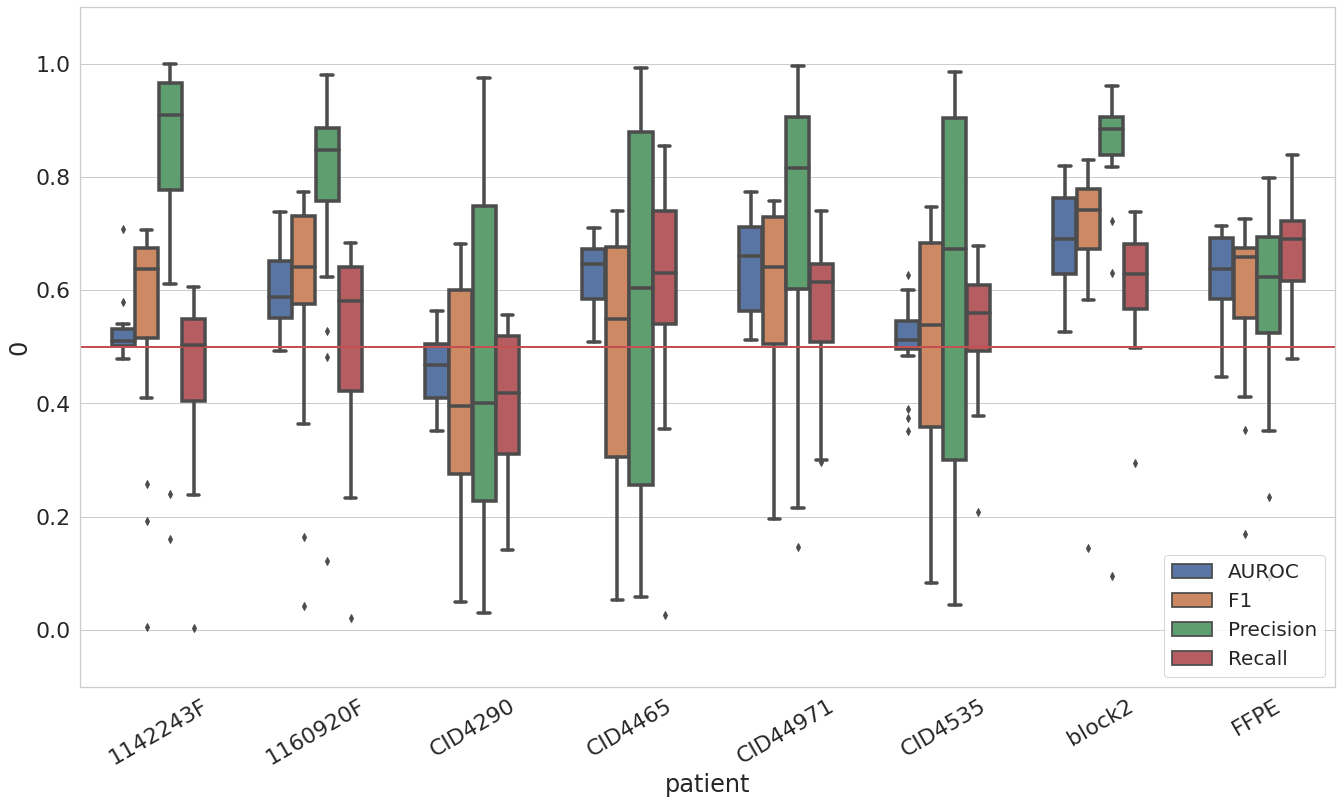

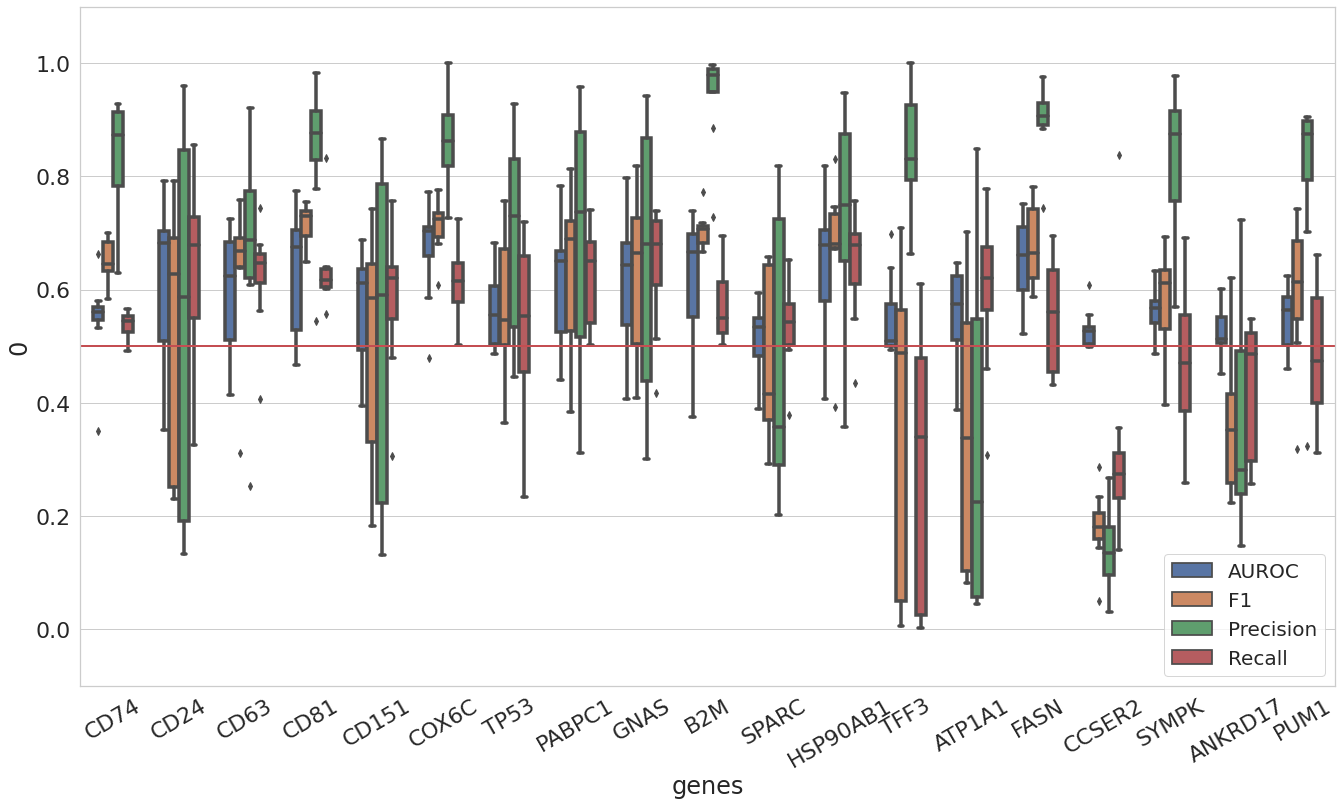

In [54]:
performance_metrics(Path,gene_exp_binary_all_true, performance_metrics_all_predictions, gene_list)
print("3-Done")

In [19]:
clustering(Path,gene_exp_binary,train_data_library_id,pred_gexp)
print("4-Done")

4-Done
